In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from torchnlp.datasets import penn_treebank_dataset
import torch
from torchnlp.samplers import BPTTBatchSampler
from torch.utils.data import DataLoader
from rsm_samplers import MNISTSequenceSampler, ptb_pred_sequence_collate
from ptb import lang_util
from util import activity_square
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.nn import CrossEntropyLoss, MSELoss
from importlib import reload 
from torch.utils.data import Sampler, BatchSampler
import rsm
from functools import reduce, partial
import matplotlib.pyplot as plt

In [2]:
reload(lang_util)
corpus = lang_util.Corpus('/Users/jgordon/nta/datasets/PTB')

print(corpus.read_out(corpus.train[:60]))

print(len(corpus.train), len(corpus.test))

aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter <eos> pierre <unk> N years old will join the board as a nonexecutive director nov. N <eos> mr. <unk> is chairman of <unk> n.v. the dutch publishing group <eos> rudolph <unk> N years old and former
929589 82430


In [4]:
import cv2
import os


def _plot_timeseries(inputs, memory, layers=2):
    steps = len(memory)
    fig, axs = plt.subplots(layers + 1, steps, dpi=144, figsize=(9, 3.3))
    for step in range(steps):
        for l in range(layers):
            ax = axs[l][step]
            ax.imshow(activity_square(memory[step][l, 0]))
            ax.axis('off')
        input_ax = axs[layers][step]
        input_ax.imshow(activity_square(inputs[step]))
        input_ax.axis('off')
    plt.show()
    
def _save_snapshot(x_b, x_b_hys, layers=2, frames_dir='./snapshots', batch_item=0, step=0):
    fig, axs = plt.subplots(layers if layers > 1 else 2, 2, figsize=(3, 5))
    for col in range(2):
        mem = x_b.detach() if col == 0 else x_b_hys.detach()
        label = 'x_b' if col == 0 else 'x_b_hys'
        for l in range(layers):
            ax = axs[layers-l-1][col]
            ax.imshow(activity_square(mem[l, batch_item]))
            ax.set_title("L%d - %s" % (l+1, label))
            ax.axis('off')
    plt.savefig(frames_dir + '/snap_batch%d_%d.png' % (batch_item, step))
    plt.close('all')
    
def timeseries_video(image_folder='./snapshots', video_name='stiched.avi'):
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    video = cv2.VideoWriter(video_name, fourcc, 5.0, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()    

In [9]:
import rsm_samplers
import rsm
from ptb import lang_util
import rsm_experiment
reload(rsm_samplers)
reload(rsm)
reload(lang_util)
reload(rsm_experiment)

VISUAL_DEBUG = False
FLAT = True
ORSM = False
HIERARCHY = False

CONFIG = {
    'debug': False,
    'path': "/Users/jgordon/nta/results",
    'data_dir': "/Users/jgordon/nta/datasets",
    'dataset': 'ptb',
    'predictor_hidden_size': 200,
    'predictor_output_size': 10000,
    'batch_size': 300,
    'batches_in_epoch': 50,
    'batches_in_first_epoch': 2,
    'vocab_size': 10000,
    'embed_dim': 28,
    'input_size': (1, 28),
    'output_size': 28,
    'eval_interval': 3,
    'eval_batch_size': 10,
    'eval_batches_in_epoch': 8200,
    'learning_rate': 0.0005,
    'pred_l2_reg': 0.000001,
    'input_bias': True,
    'eval_interval': 0,
    'eps': 0.5,
    'gamma': 0.0,
    'forget_mu': 0.02,
    'weight_sparsity': None,
    'mult_integration': False,
    'fpartition': None,
    'boost_strength_factor': 0.85,
    'boost_strat': 'col_boosting',
    'do_inhibition': False,
    'x_b_norm': True,
    'balance_part_winners': True,
    'trainable_decay': True,
    'decay_diff_plasticity': False,
    'additive_decay': True
}

if FLAT:
    CONFIG.update({
        'm_groups': 300,
        'n_cells_per_group': 1,
        'k_winners': 10,
        'k_winner_cells': 1
    })
else:
    CONFIG.update({
        'm_groups': 100,
        'n_cells_per_group': 5,
        'k_winners': 15
    })
if ORSM:
    CONFIG.update({
        'boost_strat': 'rsm_inhibition',
        'do_inhibition': True,
        'fpartition': None
    })

if HIERARCHY:
    CONFIG.update({
        'n_layers': 2,
        'feedback': True,
        'tp_boosting': False,
        'loss_layers': 'all_layers',  
        'k_winners': [10, 10],
        'boost_strength': [1.0, 0.07],
        'eps': [0.5, 0.0],
    })
    
if VISUAL_DEBUG:
    CONFIG.update({
        "visual_debug": True,
        "batch_size": 1,
        "batches_in_first_epoch": 1,
        "batches_in_epoch": 1
    })
    
exp = rsm_experiment.RSMExperiment(config=CONFIG)
exp.corpus = corpus
exp.model_setup(CONFIG)

setup: Using cpu
Maybe download PTB...
Built dataloaders...
Created <RSMLayer m=300 n=1 k=10 d_in=28 eps=0.50 /> with 107728 trainable params
Created RSMNet with 1 layer(s)


Gradients [0, 0, 0, 0]


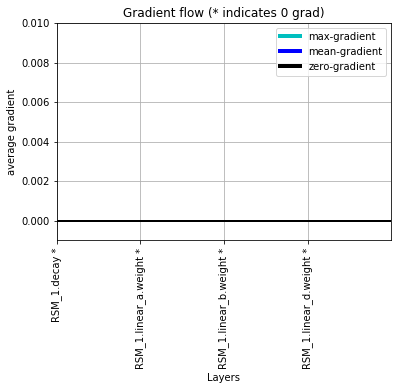

Breaking after 2 batches in epoch 0
0 {'stop': 0, 'train_loss': 0.24159735441207886, 'train_pred_ppl': 9980.898375841296, 'train_pred_acc': 0.0, 'epoch_time_train': 0.5360441207885742, 'epoch_time': 0.5361480712890625, 'learning_rate': 0.0005}
Gradients [tensor(0.), tensor(0.0037), tensor(0.), tensor(0.0176)]


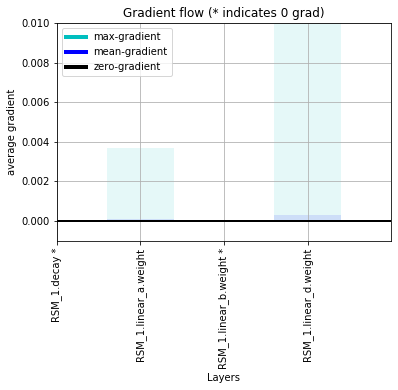

1 {'stop': 0, 'train_loss': 0.4210947960615158, 'train_pred_ppl': 9588.633301724198, 'train_pred_acc': 0.6533333333333333, 'epoch_time_train': 10.388337850570679, 'epoch_time': 10.388425827026367, 'learning_rate': 0.0005}
Gradients [tensor(3.2774e-05), tensor(0.0034), tensor(0.0001), tensor(0.0104)]


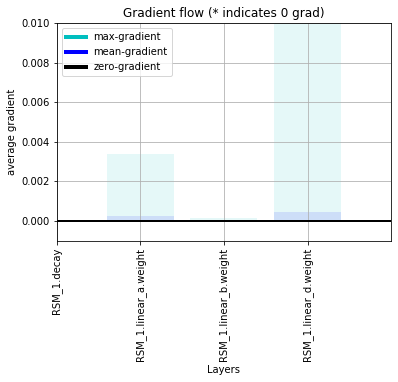

2 {'stop': 0, 'train_loss': 0.2737869444489479, 'train_pred_ppl': 7497.148466533148, 'train_pred_acc': 4.533333333333333, 'epoch_time_train': 10.341248989105225, 'epoch_time': 10.341343879699707, 'learning_rate': 0.0005}


In [10]:
input_timeseries = []
memory_timeseries = []
TIMESTEPS = 10
import util
reload(util)
from util import _plot_grad_flow

HOOK = False
ANIMATE = False

EPOCHS = 3

for epoch in range(EPOCHS):
    _plot_grad_flow(exp.model)
    plt.show()
    exp.train_epoch(epoch)

#### Confirming cross-epoch sequence continuity

In [ ]:
collate_fn = partial(rsm_samplers.ptb_pred_sequence_collate, vector_dict=bwe.embedding_dict)

sampler = rsm_samplers.PTBSequenceSampler(corpus.train, batch_size=10, max_batches=1)
loader = DataLoader(corpus.train,
                       batch_sampler=sampler,
                       collate_fn=collate_fn)


EPOCHS = 50

last_output = None

sequence = []
for i in range(EPOCHS):
    total_loss = 0.0
    input_timeseries = []
    memory_timeseries = []

    for batch_id, (inputs, target, pred_target, pred_input) in enumerate(loader):
        sequence.append(pred_input[0].item())

print(corpus.read_out(sequence))
print(len(sequence))

In [90]:
x = torch.rand(3, 10)
y = torch.rand(3, 10)
print(x)
print(y)
catted = torch.cat((x.unsqueeze(0), y.unsqueeze(0)), 0)
print(catted.size())

tensor([[0.8996, 0.2029, 0.0077, 0.1016, 0.1167, 0.5233, 0.5660, 0.7953, 0.1819,
         0.3351],
        [0.9901, 0.4842, 0.6215, 0.1780, 0.8878, 0.6848, 0.6886, 0.8453, 0.2977,
         0.0327],
        [0.6607, 0.6927, 0.2667, 0.9015, 0.6293, 0.5844, 0.2408, 0.7229, 0.6885,
         0.1949]])
tensor([[0.4374, 0.8911, 0.4127, 0.0035, 0.2117, 0.0145, 0.7387, 0.3790, 0.3167,
         0.6313],
        [0.7924, 0.4317, 0.2592, 0.5413, 0.4986, 0.1481, 0.6069, 0.7135, 0.9809,
         0.7554],
        [0.0663, 0.6803, 0.0186, 0.6123, 0.6040, 0.2357, 0.3059, 0.3596, 0.9920,
         0.2359]])
torch.Size([2, 3, 10])


## Test n-gram model on PTB

In [305]:
from random import choice
import json
from scipy.stats import mode

def bigram(data, transitions=None, ng=2, vocab_size=10000, unif_mass_pct=0.07):
    """
    Return LongTensor with probability distributions across vocab
    for each bigram in transitions dict.
    """
    if not transitions:
        transitions = {}
    ngram = []
    for token in data:
        token = token.item()
        if len(ngram) == ng:
            key = ','.join([str(x) for x in ngram])
            if key not in transitions:
                transitions[key] = torch.zeros(vocab_size).float()
            # Learn
            transitions[key][token] += 1
        ngram = ngram[-1:] + [token]
    # Make each a prob distr
    for key, val in transitions.items():
        transitions[key] += unif_mass_pct/vocab_size        
        transitions[key] = transitions[key] / transitions[key].sum()
    return transitions

def evaluate(data, transitions, ng=2, vocab_size=10000):
    n_correct = 0
    n_guesses = 0
    total_cel = 0.0
    ngram = []
    predictions = []
    targets = []
    for token in data:
        token = token.item()
        if len(ngram) == ng:
            key = ','.join([str(x) for x in ngram])
            if key in transitions:
                predict_distr = transitions[key]
            else:
                predict_distr = torch.ones(vocab_size) * 1./vocab_size
            predictions.append(predict_distr)
            targets.append(token)
        ngram = ngram[-1:] + [token]
    
    loss = torch.nn.CrossEntropyLoss()
    predictions = torch.stack(predictions)
    targets = torch.tensor(targets)
    cel = loss(predictions, targets)
    ppl = lang_util.perpl(cel)
    print("PPL: %d" % (ppl))

In [306]:
transitions = bigram(corpus.train)
print('done')

done


In [307]:
evaluate(corpus.test, transitions)

PPL: 8927


In [314]:
distr = transitions[list(transitions.keys())[6]]
max(distr)

tensor(0.9346)

In [4]:
import torch

a = torch.rand(3, 7)
b = torch.rand(3, 4)

torch.cat((a, b), dim=1).size()

torch.Size([3, 11])

In [8]:
torch.sigmoid(torch.tensor([-4.0, 4.0]))

tensor([0.0180, 0.9820])

In [1]:
from nupic.torch.modules.k_winners import KWinners
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.build_kwin()
    
    def build_kwin(self):
        self.kwin = KWinners(100, .5)
        
net = Net()

print('net.training', net.training)
print('net.kwin.training', net.kwin.training)

net.eval()

print('net.training', net.training)
print('net.kwin.training', net.kwin.training)

net.training True
net.kwin.training True
net.training False
net.kwin.training False
